In [1]:
# Использование библиотек
import osmnx as ox # основная библиотека для скачивания графа дорог и дальнейшей работы с ним
import networkx as nx # библиотека для работы с графом, почти не использовали, т.к. больше работали с osmnx
import numpy as np # для работы с матрицами
from random import random # для случайного выбора узлов и случайного назначения весов при заполнении матрицы расстояний
import json # для записи некоторых данных было удобнее использовать json формат
import csv # для записи полученной матрицы смежности и списков смежности графа
import matplotlib.pyplot as plt # для визуализации графа

### С помощью библиотеки osmnx скачиваем наш граф дорог города Казань

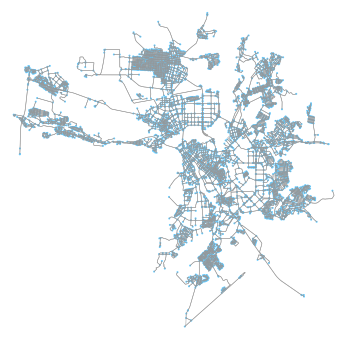

In [2]:
place = {'city' : 'Kazan',
         'country' : 'Russia'}
# наш граф
G = ox.graph_from_place(place, network_type='drive')


fig, ax = ox.plot_graph(G, edge_linewidth=0.5, node_size=4)

#### Нахождение расстояний между смежными узлами

In [20]:
# в скаченном графе уже содержится информация о расстоянии между смежными вершинами
# находим их и сохраняем в словарь следующего вида:
# {id узла} : {{id смежной с ним вершины} : расстояние между ними} 
from pprint import pprint
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})                  
pprint(dictionary[76483453]) #просто вывод для одного из узлов, чтобы посмотреть на формат

[{654650848: 276.884}, {298140601: 454.7440000000001}]


#### Создаем список из вершин графа

Он нам понадобится в дальнейшем при заполнении матрицы расстояний

In [21]:
nodes_list = list(G.nodes())

### Работа с больницами и домами

In [22]:
# пользуемся возможностыми библиотеки osmnx
# скачиваем все здания
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

#### Сохранение id больниц и домов в списки


Выбираем из первых 10000 зданий 10 больниц и 100 домов

In [23]:
# из всех зданий мы будем выбирать больницы и дома
# смотрим на то, какое имя у здания в buildings
# hospital - больница, apartments - дома
hospital = []
apartments = []
n = 10000
build = buildings.head(n)['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospital.append(key)
    elif value == 'apartments':
        apartments.append(key)

print(hospital[:10])
print(apartments[:100])

# получаем id больниц и домов, но они не являются узлами нашего графа
hospitals = hospital[:10]
apartments = apartments[:100]

# вообще, нужно выбирать рандомно, но матрица кратчайших расстояний считается больше 300 минут
# поэтому для удобства я рассматривала конкретные значения
# пример рандомного выбора реализован в Task 2, но там я тоже решила потом брать одни и те же узлы

[61424274, 61424329, 62040317, 62040327, 62040340, 72775188, 72775515, 72775583, 72775638, 72775692]
[56255883, 56255887, 56255889, 56255891, 56255892, 56255893, 56255896, 56255897, 56255898, 56255899, 56255900, 56255901, 56255906, 56255907, 56255910, 56255911, 56255912, 56255913, 56255914, 56255915, 61424177, 61424184, 61424186, 61424188, 61424193, 61424195, 61424197, 61424199, 61424203, 61424205, 61424206, 61424208, 61424209, 61424210, 61424213, 61424215, 61424229, 61424230, 61424235, 61424238, 61424246, 61424248, 61424250, 61424252, 61424256, 61424262, 61424264, 61424272, 61424280, 61424282, 61424284, 61424288, 61424290, 61424293, 61424300, 61424307, 61424309, 61424311, 61424313, 61424314, 61424315, 61424319, 61424322, 61424327, 61424332, 61424337, 61424338, 61424344, 61424348, 61424349, 61424362, 61424367, 61424373, 61424380, 61424381, 61424387, 61424389, 61424390, 61424392, 61424394, 61424396, 61424406, 61424410, 61424412, 61424416, 61424418, 61424420, 61424423, 61424428, 61424430

#### Нахождение ближайших узлов для домов и больниц

In [24]:
# ищем ближайшие узлы для наших объектов
# для этого нам нужны их географические координаты
a = buildings.head(n).to_dict()
hospitals_dict = {}
apartments_dict = {}

print('Больницы')
for i in hospitals:   
    bounds = a['geometry'][i].bounds # это и есть географические координаты, точнее - полигон (не точные координаты объекта, а примерная область, которая его ограничивает)
    # поэтому берем среднее значение соответствующих координат (широты и долготы)
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node
    # соответствие id объекта с ближайшим узлом
    print(i, nearest_node)
print('------------------')
print('Апартаменты')
for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node
    print(i, nearest_node)

Больницы
61424274 738200564
61424329 738200564
62040317 1430001830
62040327 775830916
62040340 773304756
72775188 411324758
72775515 411324765
72775583 861434955
72775638 1251018065
72775692 411324795
------------------
Апартаменты
56255883 730355743
56255887 295857558
56255889 484260741
56255891 484260736
56255892 484260739
56255893 534317522
56255896 419830632
56255897 534317522
56255898 419830632
56255899 419830632
56255900 730355768
56255901 295857558
56255906 534317530
56255907 534317530
56255910 3556716975
56255911 484262336
56255912 480690028
56255913 1174838843
56255914 446258388
56255915 1174839583
61424177 1967868583
61424184 847711650
61424186 739162326
61424188 1561540191
61424193 1571092305
61424195 1068922046
61424197 1806029749
61424199 739162327
61424203 1068922016
61424205 423155339
61424206 720459668
61424208 513783875
61424209 1967868578
61424210 972498348
61424213 766889336
61424215 1068922016
61424229 720459668
61424230 720459668
61424235 972498348
61424238 5137838

Пример визуализации кратчайшего пути от одного узла до другого

[730355743, 730355741, 730355762, 295857558, 484260746, 484260749, 484260751, 298133712, 298133761, 303473771, 298133800, 298133799, 295860426, 298133777, 423141857, 423141859, 423141866, 423141880, 423141881, 423141882, 1453450178, 423141884, 423141888, 1503879500, 1503880801, 423155321, 423155322, 423155323, 847293035, 423155324, 423155328, 1068922016, 1068921937, 1567092934, 1428936775, 738200564]


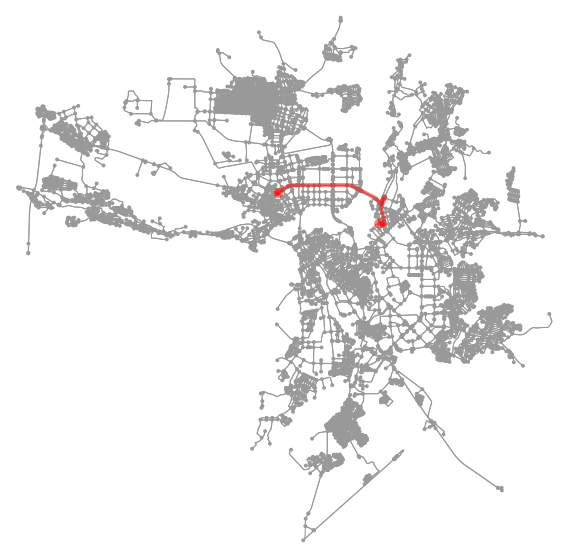

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x121f03810>)

In [25]:
route = nx.shortest_path(G,
                         730355743,
                         738200564, 
                         weight='length') 
print(route)

ox.plot_graph_route(G, route, fig_height=10, fig_width=10)

### Матрица смежности графа

In [26]:
# она тоже нам дана уже в скаченном графе G
G_pd = nx.to_pandas_adjacency(G)

In [9]:
# сохранение в csv файл дата фрейма
G_pd.to_csv('matrix_adjacency_pandas.csv')

#### Преобразовываем из датафрейма в матрицу для удобства

In [27]:
# из дата фрейма в привычный список списков
G_pd = G_pd.values

In [6]:
print(G_pd)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
# записываем матрицу смежности в csv файл
def csv_writer(data, path):
    """
    Write data to a CSV file path
    """
    with open(path, "w", newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in data:
            writer.writerow(line)

data = G_pd
path = "matrix_adjacency.csv"
csv_writer(data, path)

### Список смежности графа

In [14]:
# список смежности
list_adjacency = []
for i in range(len(G_pd)):
    temp = []
    for j in range (len(G_pd)):
        if G_pd[i][j] == 1:
            temp.append(nodes_id[j])
    list_adjacency.append(temp)

data = list_adjacency
path = "list_adjacency.csv"
csv_writer(data, path)

### Заполнение матрицы смежности расстояниями между смежными узлами

С учетом веса узлов, соответствующих больницам

In [28]:
for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1
            G_pd[i][j] = distance * weight
# здесь нужно где 0 заполнить гигантскими расстояниями для дальнейшего нахождения кратчайших путей
        if G_pd[i][j] == 0:
            G_pd[i][j] = 1000000

Создаем словарь {id узла}: {его index в списке узлов}

In [29]:
# это делается для удобства, чтобы работать не с id узлами напрямую, а с их номером
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 
# nodes_numbers

Для примера ищу расстояние между какой-то больницей и каким-то домом, оно равно 1000000, потому что это не смежные вершины

In [15]:
node1 = hospitals_dict[61424274]
index1 = nodes_numbers[node1]

node2 = apartments_dict[56255883]
index2 = nodes_numbers[node2]

print("Расстояние между этой больницей и домом: ", G_pd[index1][index2])    

Расстояние между этой больницей и домом:  1000000.0


In [30]:
# для построения дерева кратчайших путей и нахождения длины кратчайших путей используем алгоритм Дейкстры
# N - количество узлов
# S - номер вершины, из которой начинаем путь
# matrix - матрица смежности с расстояниями между узлами (у несмежных узлов расстояние 1000000)
# pred - словарь предков со следующей структурой - {номер узла} : {номер его предка}
def dijkstra(N, S, matrix, pred):
    valid = [True]*N
    weight = [1000000]*N
    weight[S] = 0
    for i in range(N):
        min_weight = 1000001
        ID_min_weight = -1
        for j in range(N):
            if valid[j] and weight[j] < min_weight:
                min_weight = weight[j]
                ID_min_weight = j
                for z in range(N):
                    if weight[ID_min_weight] + matrix[ID_min_weight][z] < weight[z]:
                        weight[z] = weight[ID_min_weight] + matrix[ID_min_weight][z]
                        pred[z] = ID_min_weight
        valid[ID_min_weight] = False
    return weight

In [31]:
# пример работы алгоритма
p = {}
dijkstra(len(G_pd), 0, G_pd, p)
# вывод дерева кратчайших путей из вершины 0, где у каждого узла указан предок
# print(p)

[0,
 124.987,
 335.626,
 461.412,
 9474.013,
 11060.177000000001,
 9766.414999999999,
 6682.163000000001,
 6670.931000000001,
 2970.3730000000005,
 7886.772999999999,
 7722.788999999999,
 25403.179000000004,
 1463.578,
 22664.183000000008,
 4695.979,
 27534.716000000004,
 7605.9839999999995,
 12245.190933842574,
 1000000,
 12256.539000000002,
 1000000,
 5152.487000000001,
 20707.073999999997,
 10843.197000000002,
 6999.540999999999,
 7248.631000000001,
 1000000,
 10583.847,
 21328.913999999997,
 10184.100999999999,
 1000000,
 23212.133000000005,
 23394.322000000007,
 9905.942999999997,
 30192.203000000012,
 29301.83400000001,
 22076.445000000003,
 23391.225000000006,
 21014.938999999995,
 21115.044999999995,
 12423.128,
 21248.411999999993,
 10331.410999999998,
 2331.8140000000003,
 19693.488999999998,
 1000000,
 23759.84600000001,
 2341.434,
 11000.464999999998,
 30094.490000000013,
 13175.260999999999,
 15135.097999999996,
 14691.513999999996,
 21102.535999999996,
 13835.215999999999

In [17]:
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())

In [18]:
# наши узлы: 100 домов и 10 больниц
new_nodes = apartments_values + hospital_values 

In [19]:
# создаем матрицу кратчайших расстояний размером 110 на 110
short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))

In [20]:
# словарь, который хранит дерево кратчайших расстояний из вершины i
pred_dict = {}
# его структура - {номер корня} : {{номер узла} : номер предка}

index_nodes = [] # индексы узлов домов и квартир! и только их!
for i in new_nodes:
    index_nodes.append(nodes_numbers[i]) # в качестве индекса номер, соответствующий id узл

In [21]:
for i in range(len(new_nodes)):
    pred = {}
    index = index_nodes[i]
    distance = dijkstra(len(G_pd), index, G_pd, pred)
    pred_dict[index] = pred
    for j in range(len(new_nodes)):
        # считаем матрицу кратчайших расстояний
        short_path_matrix[i][j] = distance[index_nodes[j]]

        
print(short_path_matrix)   

[[    0.           499.162       1031.257      ... 12688.116
  12710.783      12473.238     ]
 [  499.162          0.           532.095      ... 12188.954
  12211.621      11974.076     ]
 [  797.45         298.288          0.         ... 12458.604
  12481.271      12243.726     ]
 ...
 [11450.58635527 11317.09735527 11849.19235527 ...     0.
    369.09435527  1752.89299882]
 [11276.55693193 11143.06793193 11675.16293193 ...   398.13593193
      0.          2151.02893075]
 [11735.75306016 11602.26406016 12134.35906016 ...  1747.16991943
   2116.2642747      0.        ]]


In [22]:
for i in range(len(new_nodes)):
    for j in range(len(new_nodes)):
        if short_path_matrix[i][j] == 0 and i!=j:
            short_path_matrix[i][j] = 1000000
            

In [23]:
# это я делала на всякий случай - сохраняла матрицу в json, потому что не получалось в csv
b = short_path_matrix.tolist()
a = {'matrix':b}

with open('short_path.json','w') as f:
    json.dump(a,f)

In [24]:
with open('short_path.json','r') as f:
    a = json.load(f)

k = np.array(a['matrix'])


In [26]:
# Записываем матрицу кратчайших расстояний в csv файл

data = short_path_matrix
path = "matrix.csv"
csv_writer(data, path)

In [27]:
def find_short_path(pred_dict, index_a, index_b):
    path = []
    path.append(index_b)
    temp = index_b
    while pred_dict[index_a][temp] != index_a:
        path.append(pred_dict[index_a][temp])
        temp = pred_dict[index_a][temp]
    path.append(index_a)
    path.reverse()
    return path

In [28]:
# записываем в json файл дерево кратчайших путей
with open('short_path_tree.json', 'w') as f:
    json.dump(pred_dict, f)

In [29]:
def find_all_short_path(pred_dict):
    short_paths = {}
    for i in pred_dict.keys():
        path = {}
        for j in pred_dict[i].keys():
            path[j] = find_short_path(pred_dict, i, j)
        short_paths[i] = path
    return short_paths

short_paths = find_all_short_path(pred_dict)

# запись в json файл всех кратчайших путей
with open('short_paths.json', 'w') as f:
    json.dump(short_paths, f)

Напишем функцию для быстрого нахождения id узлов

In [30]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
    return -1

def get_id(nodes_numbers, index_nodes, i):
    temp = get_key(nodes_numbers, index_nodes[i])
    if temp == -1:
        return "Не найдено id узла"
    else:
        return temp   

### Задание 1

In [31]:
 from numpy import genfromtxt
# считываем матрицу кратчайших расстояний из csv файла
data = genfromtxt('matrix.csv', delimiter=',') 
print(data)

[[    0.           499.162       1031.257      ... 12688.116
  12710.783      12473.238     ]
 [  499.162          0.           532.095      ... 12188.954
  12211.621      11974.076     ]
 [  797.45         298.288          0.         ... 12458.604
  12481.271      12243.726     ]
 ...
 [11450.58635527 11317.09735527 11849.19235527 ...     0.
    369.09435527  1752.89299882]
 [11276.55693193 11143.06793193 11675.16293193 ...   398.13593193
      0.          2151.02893075]
 [11735.75306016 11602.26406016 12134.35906016 ...  1747.16991943
   2116.2642747      0.        ]]


#### Пункт 1

Для каждого узла (дома)

a. определить ближайший от узла объект (путь “туда”), ближайший к объекту узел
(путь “обратно”), объект расстояние (время подъезда) до которого и обратно
минимально (“туда и обратно”).

In [35]:
# если для дома под индексом 5 ближайшие больницы такие:
# "туда" имеет индекс 17 , "обратно" – 27 , "туда и обратно" – 37,
# то в возвращаемой матрице под индексом 5 будет находиться массив [17,27,37]
def find_nearest_hospitals_1a(dist_matrix, apart_count=100):
    nearest_hosp_list = [[-1 for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        nearest_hosp_list[i][0] = np.argmin(dist_matrix[i][apart_count:]) + apart_count
        nearest_hosp_list[i][1] = np.argmin(np.array(dist_matrix[apart_count:]).transpose()[i]) + apart_count
        tuda = dist_matrix[i][apart_count:]
        suda = np.array(dist_matrix[apart_count:]).transpose()[i]
        nearest_hosp_list[i][2] = np.argmin(tuda + suda) + apart_count
    return nearest_hosp_list

In [38]:
find_nearest_hospitals_1a(data)

[[102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [104, 102, 102],
 [102, 102, 102],
 [104, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [102, 102, 102],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100, 100],
 [100, 100

#### Пункт 1

Для каждого узла (дома)

b. определить объекты, расположенные не далее, чем в X км (или достижимые
не более, чем за Y минут) для каждого из трех вариантов “туда”, “обратно”,
“туда и обратно”.

In [39]:
# возвращаемый список содержит списки с 3-мя списками индексов подходящих объектов:
# "туда", "обратно" и "туда и обратно" содержат своё количество индексов - это списки второго уровня,
# индекс списка первого уровня соответствует индексу дома во входной матрице расстояний. Например,
#
# [ [ [13,14,15],[],[33,35] ],
#   [ [22],[23,24],[25,99] ] ] означает:
# для дома с индексом 0
#     "туда" допустимы больницы с индексами 13, 14 и 15
#     "обратно" допустимых больниц нет
#     "туда и обратно" допустимы больницы 33 и 35
# для дома с индексом 1
#     "туда" допустима больница с индексом 22
#     "обратно" допустимы больницы 22 и 23
#     "туда и обратно" допустимы больницы 25 и 99
def find_in_radius_1b(dist_matrix, radius, apart_count=100):
    permissible_hosps = [[[] for i in range(3)] for j in range(apart_count)]
    for i in range(apart_count):
        for j in range(apart_count, len(dist_matrix)):
            if dist_matrix[i][j] <= radius:
                permissible_hosps[i][0].append(j)
            if dist_matrix[j][i] <= radius:
                permissible_hosps[i][1].append(j)
            if dist_matrix[i][j] + dist_matrix[j][i] <= radius:
                permissible_hosps[i][2].append(j)
    return permissible_hosps

In [45]:
radius = 1000
find_in_radius_1b(data, radius)

[[[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[100, 101], [100, 101], []],
 [[], [], []],
 [[], [], []],
 [[100, 101], [100, 101], []],
 [[100, 101], [100, 101], []],
 [[100, 101], [100, 101], []],
 [[], [], []],
 [[], [], []],
 [[100, 101], [100, 101], []],
 [[], [], []],
 [[], [], []],
 [[100, 101], [100, 101], []],
 [[], [], []],
 [[], [], []],
 [[100, 101], [100, 101], []],
 [[100, 101], [100, 101], []],
 [[100, 101], [100, 101], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[], [], []],
 [[100, 101], [], []],
 [[], [], []],
 [[], [], []],
 [[100, 101], [100, 101], []],
 [[], [], []],
 [[100, 101], [100, 101], []],
 [[], 

#### Пункт 2

Определить, какой из объектов расположен так, что время/расстояние между ним и
самым дальним домом минимально (“туда”, “обратно”, “туда и обратно”).

In [46]:
# возвращаемый список содержит три больницы
# [ "туда", "обратно", "туда и обратно" ], где "туда" – из дома в больницу
def get_optimal_hospitals_2(dist_matrix, apart_count=100):
    optimal_hosps = []
    tuda = np.array(dist_matrix[:apart_count]).transpose()[apart_count:]
    optimal_hosps.append(np.argmin(np.amax(tuda, 1)) + apart_count)
    suda = np.array(dist_matrix[apart_count:])[:, :apart_count]
    optimal_hosps.append(np.argmin(np.amax(suda, 1)) + apart_count)
    tuda_suda = tuda + suda
    optimal_hosps.append(np.argmin(np.amax(tuda_suda, 1)) + apart_count)
    return optimal_hosps

In [47]:
temp = get_optimal_hospitals_2(data)

[104, 103, 102]

#### Пункт 3
Для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех
домов минимальна.

In [48]:
# возвращается индекс больницы, для которой
# сумма расстояний от неё до всех домов минимальна
def min_sum_hosp_3(dist_matrix, apart_count=100):
    dist_sums = np.array(dist_matrix[apart_count:])[:, :apart_count]
    dist_sums = np.sum(dist_sums, 1)
    return np.argmin(dist_sums) + apart_count

In [60]:
temp = min_sum_hosp_3(data)
hosp_id = get_id(nodes_numbers, index_nodes, temp)

print("Это больница с id ", hosp_id)

Это больница с id  775830916


#### Пункт 4
Для какого объекта инфраструктуры построенное дерево кратчайших путей имеет
минимальный вес.

In [74]:
# можно было без этого действия, но ладно
# соответсвие номера узла его положению в матрице кратчайших расстояний
dict_index_number = {}
for index,i in enumerate(index_nodes):
    dict_index_number[i]=index 

In [94]:
# считаем вес дерева кратчайших путей, то есть сумму его ребер
def tree_weight(tree, root, matrix):
    weight = 0
    for i in tree[root].keys():
        j = tree[root][i]
        weight += matrix[int(j)][int(i)]
    return weight

# нахождение дерева минимального веса из всех объектов
def minimal_tree(tree, matrix):
    min_value = 10000000000
    root = 0
    for i in tree.keys():
        temp = tree_weight(tree, str(i), matrix)
        print(i, temp)
        if temp < min_value:
            min_value = temp
            root = i
    return root

# нахождение дерева минимального веса, где корни - больницы
def minimal_tree_hospitals(tree, matrix, hospitals):
    min_value = 10000000000
    root = 0
    print('Номер узла - вес дерева')
    for i in hospitals:
        temp = tree_weight(tree, str(i), matrix)
        print(i,"-", temp)
        if temp < min_value:
            min_value = temp
            root = i
    return root

In [95]:
# загружаем наши деревья кратчайших путей
with open('short_path_tree.json') as f:
    short_path_tree = json.load(f)

hospitals = index_nodes[-10:]
print(hospitals)
# ищем номер корня дерева минимального веса из больниц
min_tree_root = minimal_tree_hospitals (short_path_tree, G_pd, hospitals)
print("____________________________________________________")
print("Дерево кратчайших путей минимального веса у больницы с номером", min_tree_root)

# ищем id узла
hosp_id = get_id(nodes_numbers, index_nodes, dict_index_number[min_tree_root])

print("Дерево кратчайших путей минимального веса у больницы с id", hosp_id)

[1329, 1329, 2571, 6716, 5360, 1815, 1819, 5640, 571, 1833]
Номер узла - вес дерева
1329 - 1298868.1011925002
1329 - 1298868.1011925002
2571 - 1283911.7232311023
6716 - 1284953.4536309694
5360 - 1287526.570364392
1815 - 1287308.2048969832
1819 - 1287122.2580429341
5640 - 1290263.8647041528
571 - 1292221.3522808163
1833 - 1287793.1902630695
____________________________________________________
Дерево кратчайших путей минимального веса у больницы с номером 2571
Дерево кратчайших путей минимального веса у больницы с id 1430001830


### Построение кратчайших расстояний на графе

In [97]:
with open('short_paths.json') as f:
    short_paths = json.load(f)

In [114]:
def draw_short_path(graph, short_path_list, node1, node2, height, width):
    path = short_path_list[str(node1)][str(node2)]
    route = []
    for i in path:
        key = get_key(nodes_numbers, i)
        route.append(key)      
    ox.plot_graph_route(graph, route, fig_height=height, fig_width=width)
    

In [ ]:
# пример построения на графе кратчайшего пути
draw_short_path(G, short_paths, 2499, 5539, 10, 10)